In [ ]:
import numpy as np
import soundfile as sf
from scipy.signal import stft, istft
import matplotlib.pyplot as plt


In [9]:
def make_mono_audio(frequency_hz: int,
                    write_wav: bool = False,
                    duration_s: float = 1.0,
                    sample_rate: int = 44100) -> np.ndarray:
    """
    Generate a mono sine wave.

    Args:
        frequency_hz: Sine frequency in Hz.
        write_wav: If True, save as 'sine.wav'.
        duration_s: Length in seconds.
        sample_rate: Samples per second.
    Returns:
        1D NumPy array of floats.
    """
    t = np.linspace(0,
                    duration_s,
                    int(sample_rate * duration_s),
                    endpoint=False)
    signal = np.sin(2 * np.pi * frequency_hz * t)
    if write_wav:
        sf.write("sine.wav",
                 signal.astype(np.float32),
                 sample_rate)
    return signal


In [55]:
def make_noisy_mono_audio(
    frequency: int,
    duration: float = 1.0,
    sampling_rate: int = 16000,
    snr_db: float = 20,
    write_file: bool = False,
    filename: str = "generated_noisy_sine.wav"
) -> np.ndarray:
    """
    Generates a mono sine wave audio signal with additive Gaussian noise.

    Args:
        frequency (int): Frequency of the sine wave in Hz.
        duration (float): Duration of the generated sine wave in seconds (default: 1.0s).
        sampling_rate (int): Sampling rate in Hz (default: 16000 Hz).
        snr_db (float): Signal-to-Noise Ratio in decibels (default: 20 dB).
        write_file (bool): If True, saves the generated audio as a WAV file (default: False).
        filename (str): Name of the file to save if write_file is True.

    Returns:
        np.ndarray: NumPy array containing the generated noisy sine wave (float32).
    """
    num_samples = int(sampling_rate * duration)
    t = np.linspace(0, duration, num_samples, endpoint=False)
    signal = np.sin(2 * np.pi * frequency * t).astype(np.float32)
    
    # Generate noise
    noise = np.random.normal(0, 1, num_samples).astype(np.float32)
    
    # Calculate scaling factor for desired SNR
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    scale = np.sqrt(signal_power / (noise_power * 10**(snr_db/10)))
    
    # Add scaled noise to signal
    result = signal + scale * noise
    
    if write_file:
        try:
            write(filename, sampling_rate, result)
            print(f"Noisy audio saved to {filename}")
        except Exception as e:
            print(f"Error writing WAV file {filename}: {e}")
    
    return result

In [10]:
def create_delay_vector(sound_speed: float,
                        angle_rad: float,
                        num_mics: int,
                        mic_spacing: float) -> np.ndarray:
    """
    Compute per-microphone time delays for a plane wave.

    Args:
        sound_speed: Speed of sound in m/s.
        angle_rad: Arrival angle in radians (broadside = 0).
        num_mics: Number of microphones.
        mic_spacing: Distance between taps in meters.
    Returns:
        1D array of length num_mics.
    """
    positions = np.arange(num_mics) * mic_spacing
    return -positions * np.sin(angle_rad) / sound_speed

def set_steering_vector(delay_vector: np.ndarray,
                        fft_size: int,
                        sample_rate: int) -> np.ndarray:
    """
    Build a frequency-domain steering matrix.

    Args:
        delay_vector: Time delays for each microphone.
        fft_size: FFT length.
        sample_rate: Samples per second.
    Returns:
        Array of shape (fft_size//2+1, num_mics).
    """
    freqs = np.fft.rfftfreq(fft_size, d=1/sample_rate)
    return np.exp(-1j * 2 * np.pi * freqs[:, None] * delay_vector)

def delay_across_channels_py_freq(signal: np.ndarray,
                                  look_angle_deg: float,
                                  num_mics: int,
                                  mic_spacing: float,
                                  sample_rate: int,
                                  sound_speed: float = 343.0) -> np.ndarray:
    """
    Delay a mono signal across a ULA of microphones.

    Args:
        signal: 1D mono input.
        look_angle_deg: Steering angle in degrees.
        num_mics: Number of microphones.
        mic_spacing: Distance between mics in meters.
        sample_rate: Samples per second.
        sound_speed: Speed of sound in m/s.
    Returns:
        2D array (samples × num_mics).
    """
    if signal.ndim == 1:
        signal = signal[:, None]

    angle_rad = np.radians(-look_angle_deg)
    fft_size = len(signal)
    signal_fd = np.fft.rfft(signal, axis=0)

    delays = create_delay_vector(sound_speed,
                                 angle_rad,
                                 num_mics,
                                 mic_spacing)
    steering = set_steering_vector(delays,
                                   fft_size,
                                   sample_rate)

    multi_fd = np.tile(signal_fd, (1, num_mics)) * steering
    return np.fft.irfft(multi_fd, axis=0)


Max response at 44.19° → amplitude 1.020531


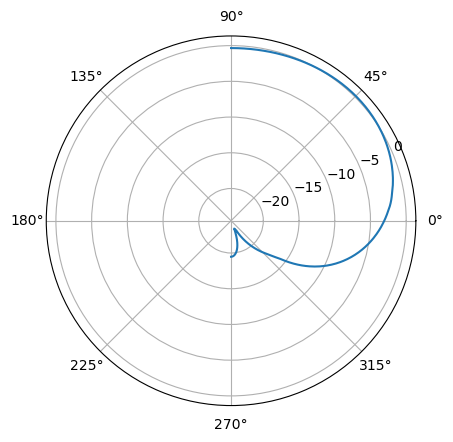

In [ ]:
# Configuration
sound_speed    = 343.0
sample_rate    = 44100
num_mics       = 8
mic_spacing    = 0.04
fft_size       = 1024
hop_size       = fft_size // 2
window_type    = "hamming"
target_deg     = 45  # beam toward +45°

# Precompute MVDR steering for target_deg
freqs          = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions  = np.arange(num_mics) * mic_spacing
steering_mat   = np.exp(
    -1j * 2 * np.pi
    * freqs[:, None]
    * mic_positions[None, :]
    * np.cos(np.radians(target_deg))
    / sound_speed
)

# Generate test tone
signal = make_mono_audio(700,
                         write_wav=False,
                         duration_s=5,
                         sample_rate=sample_rate)

angles      = np.linspace(-90, 90, 500)
angle_rads  = np.radians(angles)
responses_db = []

best_angle   = None
max_amplitude = -np.inf

for ang_deg, ang_rad in zip(angles, angle_rads):
    # apply delay for this arrival angle
    multich = delay_across_channels_py_freq(
        signal,
        ang_deg,
        num_mics,
        mic_spacing,
        sample_rate,
        sound_speed
    )

    # STFT: shape (mics, freqs, frames)
    _, _, spec = stft(
        multich.T,
        fs=sample_rate,
        window=window_type,
        nperseg=fft_size,
        noverlap=hop_size,
        axis=-1
    )

    # assume identity matrix covariance
    Rn = np.tile(np.eye(num_mics),
                 (len(freqs), 1, 1))

    # compute MVDR weights
    spec = spec.transpose(1, 0, 2)  # (freqs, mics, frames)
    W = np.empty_like(steering_mat, dtype=np.complex128)
    for k in range(len(freqs)):
        v = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics),
                            steering_mat[k])
        denom = steering_mat[k].conj() @ v
        W[k] = v / denom

    # beamform and invert STFT
    Y = np.sum(np.conj(W)[..., None] * spec, axis=1)
    _, out_time = istft(
        Y,
        fs=sample_rate,
        window=window_type,
        nperseg=fft_size,
        noverlap=hop_size
    )

    amp = np.max(np.abs(out_time))
    if amp > max_amplitude:
        max_amplitude = amp
        best_angle = ang

    db = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
    responses_db.append(db)

print(f"Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
plt.polar(angle_rads, responses_db)
plt.show()


Max response at 44.188377° → amplitude 1.020471


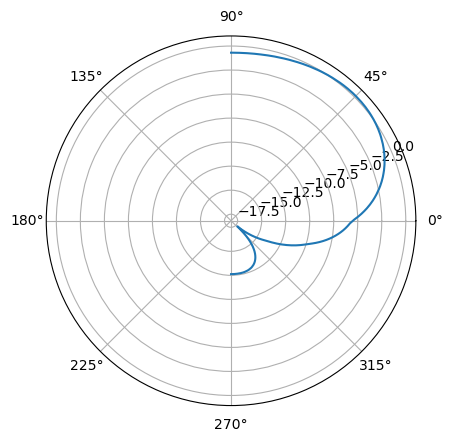

In [ ]:
# Configuration
sound_speed    = 343.0
sample_rate    = 44100
num_mics       = 8
mic_spacing    = 0.04
fft_size       = 1024
hop_size       = fft_size // 2
window_type    = "hamming"
target_deg     = 45  # beam toward +45°
signal_freq_hz = 900   # Frequency of the test signal
signal_duration_s = 3.0

# Precompute MVDR steering for target_deg
freqs          = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions  = np.arange(num_mics) * mic_spacing
steering_mat   = np.exp(
    -1j * 2 * np.pi
    * freqs[:, None]
    * mic_positions[None, :]
    * np.cos(np.radians(target_deg))
    / sound_speed
)

# Generate test tone
signal = make_mono_audio(signal_freq_hz,
                         write_wav=False,
                         duration_s=signal_duration_s,
                         sample_rate=sample_rate)

angles      = np.linspace(-90, 90, 500)
angle_rads  = np.radians(angles)
responses_db = []

best_angle   = None
max_amplitude = -np.inf

for ang_deg, ang_rad in zip(angles, angle_rads):
    # apply delay for this arrival angle
    multich = delay_across_channels_py_freq(
        signal,
        ang_deg,
        num_mics,
        mic_spacing,
        sample_rate,
        sound_speed
    )

    # STFT: shape (mics, freqs, frames)
    _, _, spec = stft(
        multich.T,
        fs=sample_rate,
        window=window_type,
        nperseg=fft_size,
        noverlap=hop_size,
        axis=-1
    )

    # assume identity matrix covariance
    Rn = np.tile(np.eye(num_mics),
                 (len(freqs), 1, 1))

    # compute MVDR weights
    spec = spec.transpose(1, 0, 2)  # (freqs, mics, frames)
    W = np.empty_like(steering_mat, dtype=np.complex128)
    for k in range(len(freqs)):
        v = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics),
                            steering_mat[k])
        denom = steering_mat[k].conj() @ v
        W[k] = v / denom

    # beamform and invert STFT
    Y = np.sum(np.conj(W)[..., None] * spec, axis=1)
    _, out_time = istft(
        Y,
        fs=sample_rate,
        window=window_type,
        nperseg=fft_size,
        noverlap=hop_size
    )

    amp = np.max(np.abs(out_time))
    if amp > max_amplitude:
        max_amplitude = amp
        best_angle = ang_deg

    db = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
    responses_db.append(db)

print(f"Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
plt.polar(angle_rads, responses_db)
plt.title(f"Target: {target_deg}°, Frequency: {signal_freq_hz} Hz")
plt.xlabel("Angle (degrees)")
plt.ylabel("Response (dB)")
plt.show()


Frequency: 200, Max response at 45.000000° → amplitude 1.020631
Frequency: 500, Max response at 45.000000° → amplitude 1.020616
Frequency: 700, Max response at 46.000000° → amplitude 1.020516
Frequency: 1000, Max response at 45.000000° → amplitude 1.020620
Frequency: 1300, Max response at 45.000000° → amplitude 1.020620
Frequency: 1600, Max response at 45.000000° → amplitude 1.020615


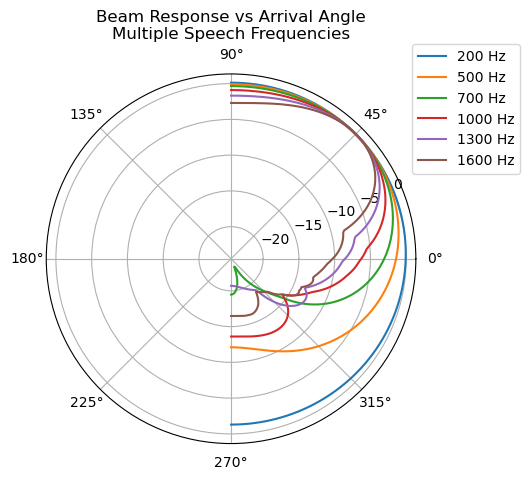

In [51]:
# Parameters
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.04
fft_size    = 1024
hop_size    = fft_size // 2
window_type = "hamming"
target_deg  = 45
duration_s = 1.0

# Sweep angles every 1 degree
angles     = np.arange(-90, 91, 1)
angle_rads = np.radians(angles)

# Precompute steering for MVDR weights
freq_bins     = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions = np.arange(num_mics) * mic_spacing
steering_mat  = np.exp(
    -1j * 2 * np.pi
    * freq_bins[:, None]
    * mic_positions[None, :]
    * np.sin(np.radians(target_deg))
    / sound_speed
)

# Compute MVDR weights once
Rn = np.tile(np.eye(num_mics), (len(freq_bins), 1, 1))
W = np.empty_like(steering_mat, dtype=np.complex128)
for k in range(len(freq_bins)):
    v    = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics), steering_mat[k])
    W[k] = v / (steering_mat[k].conj() @ v)

# Frequencies to test (speech band)
test_freqs = [200, 500, 700, 1000, 1300, 1600]

# Plot all beam patterns on one polar plot
fig = plt.figure()
ax  = fig.add_subplot(projection='polar')

for f_hz in test_freqs:
    max_amplitude = -np.inf
    best_angle    = None
    signal       = make_mono_audio(f_hz, duration_s=duration_s, sample_rate=sample_rate)
    responses_db = []

    for ang in angles:
        multi_ch = delay_across_channels_py_freq(
            signal, ang, num_mics, mic_spacing, sample_rate, sound_speed
        )
        _, _, spec = stft(
            multi_ch.T,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size,
            axis=-1
        )
        spec_f = spec.transpose(1, 0, 2)
        Y      = np.sum(np.conj(W)[..., None] * spec_f, axis=1)
        _, out = istft(
            Y,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size
        )
        amp = np.max(np.abs(out))
        
        if amp > max_amplitude:
            max_amplitude = amp
            best_angle = ang
        
        db  = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
        responses_db.append(db)

    print(f"Frequency: {f_hz}, Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
    ax.plot(angle_rads, responses_db, label=f"{f_hz} Hz")

ax.set_title("Beam Response vs Arrival Angle\nMultiple Speech Frequencies")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

Frequency: 200, Max response at 46.000000° → amplitude 1.010573
Frequency: 500, Max response at 45.000000° → amplitude 1.010546
Frequency: 700, Max response at 47.000000° → amplitude 1.010451
Frequency: 1000, Max response at 45.000000° → amplitude 1.010525
Frequency: 1300, Max response at 45.000000° → amplitude 1.010552
Frequency: 1600, Max response at 45.000000° → amplitude 1.010527


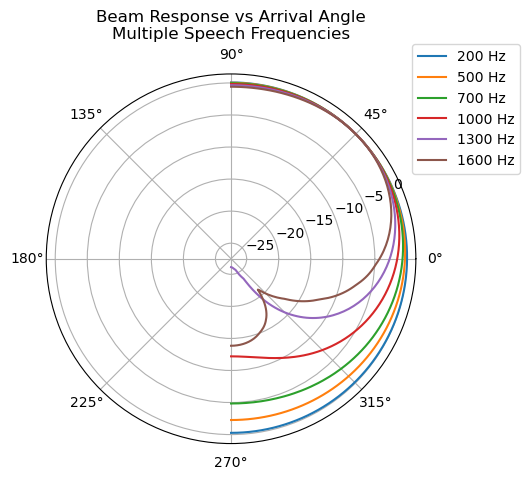

In [ ]:
# Parameters
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.02 # 2 cm spacing
fft_size    = 1024
hop_size    = fft_size // 2
window_type = "hamming"
target_deg  = 45
duration_s = 1.0

# Sweep angles every 1 degree
angles     = np.arange(-90, 91, 1)
angle_rads = np.radians(angles)

# Precompute steering for MVDR weights
freq_bins     = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions = np.arange(num_mics) * mic_spacing
steering_mat  = np.exp(
    -1j * 2 * np.pi
    * freq_bins[:, None]
    * mic_positions[None, :]
    * np.sin(np.radians(target_deg))
    / sound_speed
)

# Compute MVDR weights once
Rn = np.tile(np.eye(num_mics), (len(freq_bins), 1, 1))
W = np.empty_like(steering_mat, dtype=np.complex128)
for k in range(len(freq_bins)):
    v    = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics), steering_mat[k])
    W[k] = v / (steering_mat[k].conj() @ v)

# Frequencies to test (speech band)
test_freqs = [200, 500, 700, 1000, 1300, 1600]

# Plot all beam patterns on one polar plot
fig = plt.figure()
ax  = fig.add_subplot(projection='polar')

for f_hz in test_freqs:
    max_amplitude = -np.inf
    best_angle    = None
    signal       = make_noisy_mono_audio(f_hz, duration_s=duration_s, sample_rate=sample_rate)
    responses_db = []

    for ang in angles:
        multi_ch = delay_across_channels_py_freq(
            signal, ang, num_mics, mic_spacing, sample_rate, sound_speed
        )
        _, _, spec = stft(
            multi_ch.T,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size,
            axis=-1
        )
        spec_f = spec.transpose(1, 0, 2)
        Y      = np.sum(np.conj(W)[..., None] * spec_f, axis=1)
        _, out = istft(
            Y,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size
        )
        amp = np.max(np.abs(out))
        
        if amp > max_amplitude:
            max_amplitude = amp
            best_angle = ang
        
        db  = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
        responses_db.append(db)

    print(f"Frequency: {f_hz}, Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
    ax.plot(angle_rads, responses_db, label=f"{f_hz} Hz")

ax.set_title("Beam Response vs Arrival Angle\nMultiple Speech Frequencies")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

Frequency: 200, Max response at 45.000000° → amplitude 1.303366
Frequency: 500, Max response at 45.000000° → amplitude 1.360724
Frequency: 700, Max response at 45.000000° → amplitude 1.330028
Frequency: 1000, Max response at 45.000000° → amplitude 1.300209
Frequency: 1300, Max response at 45.000000° → amplitude 1.295895
Frequency: 1600, Max response at 45.000000° → amplitude 1.289277


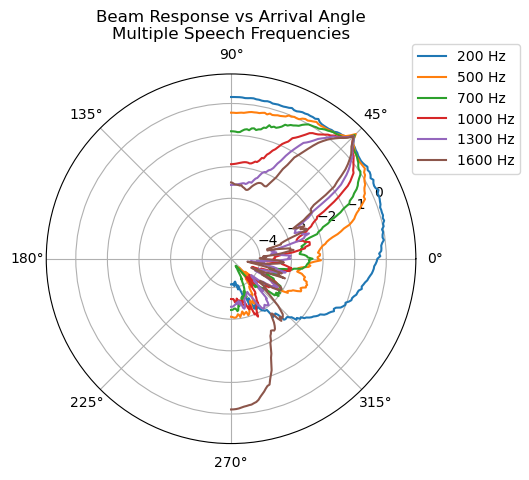

In [62]:
# Parameters
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.12 # 12 cm spacing
fft_size    = 1024
hop_size    = fft_size // 2
window_type = "hamming"
target_deg  = 45
duration_s = 1.0

# Sweep angles every 1 degree
angles     = np.arange(-90, 91, 1)
angle_rads = np.radians(angles)

# Precompute steering for MVDR weights
freq_bins     = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions = np.arange(num_mics) * mic_spacing
steering_mat  = np.exp(
    -1j * 2 * np.pi
    * freq_bins[:, None]
    * mic_positions[None, :]
    * np.sin(np.radians(target_deg))
    / sound_speed
)

# Compute MVDR weights once
Rn = np.tile(np.eye(num_mics), (len(freq_bins), 1, 1))
W = np.empty_like(steering_mat, dtype=np.complex128)
for k in range(len(freq_bins)):
    v    = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics), steering_mat[k])
    W[k] = v / (steering_mat[k].conj() @ v)

# Frequencies to test (speech band)
test_freqs = [200, 500, 700, 1000, 1300, 1600]

# Plot all beam patterns on one polar plot
fig = plt.figure()
ax  = fig.add_subplot(projection='polar')

for f_hz in test_freqs:
    max_amplitude = -np.inf
    best_angle    = None
    signal       = make_noisy_mono_audio(f_hz, duration=duration_s, sampling_rate=sample_rate)
    responses_db = []

    for ang in angles:
        multi_ch = delay_across_channels_py_freq(
            signal, ang, num_mics, mic_spacing, sample_rate, sound_speed
        )
        _, _, spec = stft(
            multi_ch.T,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size,
            axis=-1
        )
        spec_f = spec.transpose(1, 0, 2)
        Y      = np.sum(np.conj(W)[..., None] * spec_f, axis=1)
        _, out = istft(
            Y,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size
        )
        amp = np.max(np.abs(out))
        
        if amp > max_amplitude:
            max_amplitude = amp
            best_angle = ang
        
        db  = 5*np.log10(amp) if 5*np.log10(amp) >= -50 else -50
        responses_db.append(db)

    print(f"Frequency: {f_hz}, Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
    ax.plot(angle_rads, responses_db, label=f"{f_hz} Hz")

ax.set_title("Beam Response vs Arrival Angle\nMultiple Speech Frequencies")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

Frequency: 200, Max response at 14.000000° → amplitude 1.003904
Frequency: 500, Max response at 15.000000° → amplitude 1.003911
Frequency: 700, Max response at 14.000000° → amplitude 1.003824
Frequency: 1000, Max response at 15.000000° → amplitude 1.003916
Frequency: 1300, Max response at 15.000000° → amplitude 1.003944
Frequency: 1600, Max response at 19.000000° → amplitude 1.005300


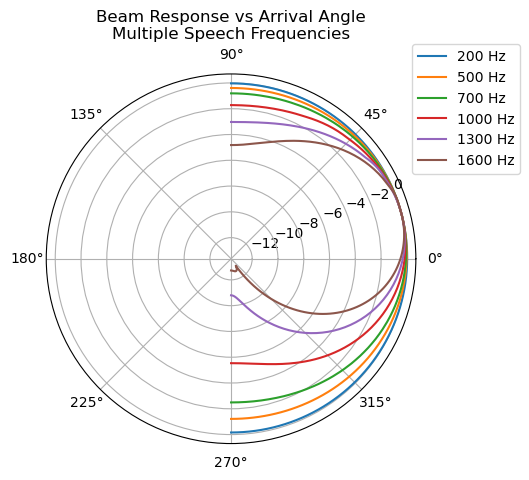

In [ ]:
# Parameters
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.02 # 2 cm spacing
fft_size    = 1024
hop_size    = fft_size // 2
window_type = "hamming"
target_deg  = 15
duration_s = 1.0

# Sweep angles every 1 degree
angles     = np.arange(-90, 91, 1)
angle_rads = np.radians(angles)

# Precompute steering for MVDR weights
freq_bins     = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions = np.arange(num_mics) * mic_spacing
steering_mat  = np.exp(
    -1j * 2 * np.pi
    * freq_bins[:, None]
    * mic_positions[None, :]
    * np.sin(np.radians(target_deg))
    / sound_speed
)

"""
# X shape: (M , F , T)

# ---- ❸ estimate spatial covariance of noise R_n(f)  ----------------------
# Simple approach: use initial 0.5 s as “noise-only”; improve with VAD if needed
# noise_samples   = int(0.5 * fs)
# _, _, X_noise   = stft(audio[:noise_samples].T, fs=fs, window=window,
#                     nperseg=win_len, noverlap=hop, axis=-1)
# Rn = np.einsum("mft,nft->fmn", X_noise, np.conj(X_noise)) / X_noise.shape[-1]  # (F,M,M)
"""


# Compute MVDR weights once
Rn = np.tile(np.eye(num_mics), (len(freq_bins), 1, 1))
W = np.empty_like(steering_mat, dtype=np.complex128)
for k in range(len(freq_bins)):
    v    = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics), steering_mat[k])
    W[k] = v / (steering_mat[k].conj() @ v)

# Frequencies to test (speech band)
test_freqs = [200, 500, 700, 1000, 1300, 1600]

# Plot all beam patterns on one polar plot
fig = plt.figure()
ax  = fig.add_subplot(projection='polar')

for f_hz in test_freqs:
    max_amplitude = -np.inf
    best_angle    = None
    signal       = make_mono_audio(f_hz, duration_s=duration_s, sample_rate=sample_rate)
    responses_db = []

    for ang in angles:
        multi_ch = delay_across_channels_py_freq(
            signal, ang, num_mics, mic_spacing, sample_rate, sound_speed
        )
        _, _, spec = stft(
            multi_ch.T,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size,
            axis=-1
        )
        spec_f = spec.transpose(1, 0, 2)
        Y      = np.sum(np.conj(W)[..., None] * spec_f, axis=1)
        _, out = istft(
            Y,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size
        )
        amp = np.max(np.abs(out))
        
        if amp > max_amplitude:
            max_amplitude = amp
            best_angle = ang
        
        db  = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
        responses_db.append(db)

    print(f"Frequency: {f_hz}, Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
    ax.plot(angle_rads, responses_db, label=f"{f_hz} Hz")

ax.set_title("Beam Response vs Arrival Angle\nMultiple Speech Frequencies")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

Frequency: 200, Max response at -29.000000° → amplitude 1.007512
Frequency: 500, Max response at -30.000000° → amplitude 1.007503
Frequency: 700, Max response at -29.000000° → amplitude 1.007407
Frequency: 1000, Max response at -30.000000° → amplitude 1.007503
Frequency: 1300, Max response at -30.000000° → amplitude 1.007505
Frequency: 1600, Max response at -30.000000° → amplitude 1.007502


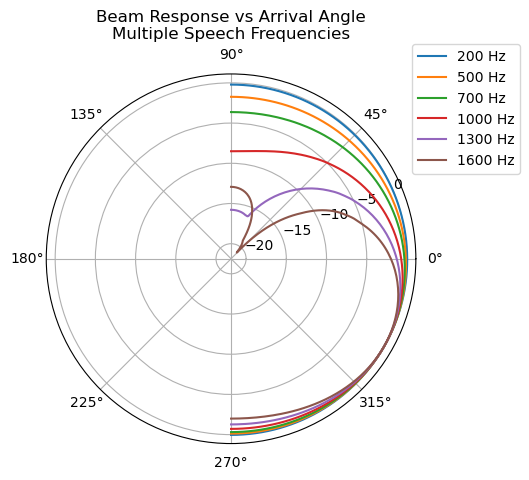

In [54]:
# Parameters
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.02 # 2 cm spacing
fft_size    = 1024
hop_size    = fft_size // 2
window_type = "hamming"
target_deg  = -30
duration_s = 1.0

# Sweep angles every 1 degree
angles     = np.arange(-90, 91, 1)
angle_rads = np.radians(angles)

# Precompute steering for MVDR weights
freq_bins     = np.fft.rfftfreq(fft_size, d=1/sample_rate)
mic_positions = np.arange(num_mics) * mic_spacing
steering_mat  = np.exp(
    -1j * 2 * np.pi
    * freq_bins[:, None]
    * mic_positions[None, :]
    * np.sin(np.radians(target_deg))
    / sound_speed
)

# Compute MVDR weights once
Rn = np.tile(np.eye(num_mics), (len(freq_bins), 1, 1))
W = np.empty_like(steering_mat, dtype=np.complex128)
for k in range(len(freq_bins)):
    v    = np.linalg.solve(Rn[k] + 1e-6*np.eye(num_mics), steering_mat[k])
    W[k] = v / (steering_mat[k].conj() @ v)

# Frequencies to test (speech band)
test_freqs = [200, 500, 700, 1000, 1300, 1600]

# Plot all beam patterns on one polar plot
fig = plt.figure()
ax  = fig.add_subplot(projection='polar')

for f_hz in test_freqs:
    max_amplitude = -np.inf
    best_angle    = None
    signal       = make_mono_audio(f_hz, duration_s=duration_s, sample_rate=sample_rate)
    responses_db = []

    for ang in angles:
        multi_ch = delay_across_channels_py_freq(
            signal, ang, num_mics, mic_spacing, sample_rate, sound_speed
        )
        _, _, spec = stft(
            multi_ch.T,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size,
            axis=-1
        )
        spec_f = spec.transpose(1, 0, 2)
        Y      = np.sum(np.conj(W)[..., None] * spec_f, axis=1)
        _, out = istft(
            Y,
            fs=sample_rate,
            window=window_type,
            nperseg=fft_size,
            noverlap=hop_size
        )
        amp = np.max(np.abs(out))
        
        if amp > max_amplitude:
            max_amplitude = amp
            best_angle = ang
        
        db  = 20*np.log10(amp) if 20*np.log10(amp) >= -50 else -50
        responses_db.append(db)

    print(f"Frequency: {f_hz}, Max response at {best_angle:.6f}° → amplitude {max_amplitude:.6f}")
    ax.plot(angle_rads, responses_db, label=f"{f_hz} Hz")

ax.set_title("Beam Response vs Arrival Angle\nMultiple Speech Frequencies")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [ ]:
import torch
import math
import soundfile as sf
import matplotlib.pyplot as plt

In [28]:
def make_mono_audio_torch(frequency_hz: int,
                     write_wav: bool = False,
                     duration_s: float = 1.0,
                     sample_rate: int = 44100) -> torch.Tensor:
    """
    Generate a mono sine wave using PyTorch.

    Args:
        frequency_hz: Sine frequency in Hz.
        write_wav: If True, save as 'sine_torch.wav'.
        duration_s: Length in seconds.
        sample_rate: Samples per second.
    Returns:
        1D tensor of shape (samples,).
    """
    num_samples = int(sample_rate * duration_s)
    t = torch.arange(num_samples, dtype=torch.float32) / sample_rate
    signal = torch.sin(2 * math.pi * frequency_hz * t)
    if write_wav:
        sf.write("sine_torch.wav",
                 signal.numpy().astype("float32"),
                 sample_rate)
    return signal


In [29]:
def create_delay_vector_torch(sound_speed: float,
                         angle_rad: float,
                         num_mics: int,
                         mic_spacing: float) -> torch.Tensor:
    """
    Compute per-mic time delays for a plane wave using PyTorch.

    Args:
        sound_speed: Speed of sound in m/s.
        angle_rad: Arrival angle in radians (broadside = 0).
        num_mics: Number of microphones.
        mic_spacing: Distance between mics in meters.
    Returns:
        Tensor of shape (num_mics,).
    """
    # Ensure positions are float for calculations
    positions = torch.arange(num_mics, dtype=torch.float32) * mic_spacing
    return -positions * math.sin(angle_rad) / sound_speed

def set_steering_vector_torch(delay_vector: torch.Tensor,
                         fft_size: int,
                         sample_rate: int) -> torch.Tensor:
    """
    Build frequency-domain steering matrix using PyTorch.

    Args:
        delay_vector: Time delays for each mic (num_mics,).
        fft_size: FFT length.
        sample_rate: Samples per second.
    Returns:
        Complex tensor of shape (fft_size//2+1, num_mics).
    """
    freqs = torch.fft.rfftfreq(fft_size, d=1/sample_rate)
    # Use 1j for complex numbers, ensure broadcasting is correct
    phase = 2 * math.pi * freqs[:, None] * delay_vector[None, :]
    return torch.exp(-1j * phase) # Use 1j for imaginary unit

def delay_across_channels_py_freq_torch(signal: torch.Tensor,
                                   look_angle_deg: float,
                                   num_mics: int,
                                   mic_spacing: float,
                                   sample_rate: int,
                                   sound_speed: float = 343.0) -> torch.Tensor:
    """
    Delay a mono signal across a linear mic array in frequency domain using PyTorch.

    Args:
        signal: 1D tensor of shape (samples,).
        look_angle_deg: Steering angle in degrees.
        num_mics: Number of mics.
        mic_spacing: Spacing in meters.
        sample_rate: Samples per second.
        sound_speed: Speed of sound.
    Returns:
        2D tensor of shape (samples, num_mics).
    """
    if signal.ndim == 1:
        signal = signal[:, None] # Add channel dim: (samples, 1)

    n_samples = signal.shape[0]
    angle_rad = math.radians(-look_angle_deg) # Convention might differ, ensure consistency
    signal_fd = torch.fft.rfft(signal, n=n_samples, dim=0) # shape (n_freq, 1)

    delays = create_delay_vector_torch(sound_speed,
                                  angle_rad,
                                  num_mics,
                                  mic_spacing)
    steering = set_steering_vector_torch(delays,
                                    n_samples, # Use signal length for FFT size here
                                    sample_rate) # shape (n_freq, num_mics)

    # Repeat signal across mic dim and apply steering phase shifts
    # signal_fd shape: (n_freq, 1) -> repeat -> (n_freq, num_mics)
    multi_fd = signal_fd.repeat(1, num_mics) * steering
    # Output shape: (n_samples, num_mics)
    return torch.fft.irfft(multi_fd, n=n_samples, dim=0)


Max response at 43.827656° → amplitude 1.021021


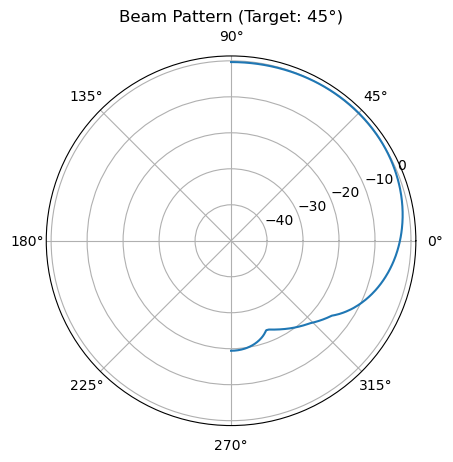

In [31]:
# constants
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.04
fft_size    = 1024 # STFT frame size
hop_size    = fft_size // 2
# Match numpy/scipy default: symmetric (non-periodic) window
window      = torch.hamming_window(fft_size, periodic=False)
target_deg  = 45   # beam direction

# precompute steering matrix for MVDR (using STFT fft_size)
freqs = torch.fft.rfftfreq(fft_size, d=1/sample_rate) # Use STFT fft_size
positions = torch.arange(num_mics, dtype=torch.float32) * mic_spacing
target_rad = math.radians(target_deg)

beam_steering = torch.exp(
    -1j * 2 * math.pi
    * freqs[:, None]
    * positions[None, :]
    * math.cos(target_rad) # Original numpy code used cos here
    / sound_speed
).to(torch.complex64) # Ensure complex64

# test tone
signal = make_mono_audio_torch(700,
                                write_wav=False,
                                duration_s=5,
                                sample_rate=sample_rate)
original_signal_length = signal.shape[0] # Store original length

angles       = torch.linspace(-90, 90, 500) # Test angles
responses_db = []
best_angle   = 0.0
max_amp      = -float("inf")

for ang in angles:
    ang_deg = ang.item()
    # simulate arrival at ang_deg using the frequency domain delay function
    multich = delay_across_channels_py_freq_torch(signal,
                                                ang_deg,
                                                num_mics,
                                                mic_spacing,
                                                sample_rate,
                                                sound_speed)
    # --- Beamforming ---
    # STFT: Input shape (num_mics, samples) -> output (num_mics, freq_bins, frames)
    spec = torch.stft(multich.T, # Transpose to (num_mics, samples)
                        n_fft=fft_size,
                        hop_length=hop_size,
                        win_length=fft_size,
                        window=window,
                        return_complex=True,
                        center=True, # Use centering like scipy default
                        pad_mode="constant") # Default padding

    # reorder to (freq_bins, num_mics, frames) for MVDR calculation
    spec = spec.permute(1, 0, 2)
    n_freq_bins = spec.shape[0] # Actual number of freq bins from STFT

    # assume white noise covariance: batch of identity matrices
    # Ensure dtype matches spec and beam_steering complex type
    Rn = torch.eye(num_mics, dtype=torch.complex64).unsqueeze(0).repeat(n_freq_bins, 1, 1)

    # MVDR weights per frequency
    # Ensure W has the correct complex dtype
    W = torch.empty_like(beam_steering, dtype=torch.complex64)
    for k in range(n_freq_bins): # Iterate up to actual freq bins
        # Add regularization (jitter)
        R = Rn[k] + 1e-6 * torch.eye(num_mics, dtype=torch.complex64)
        a = beam_steering[k] # Steering vector for this frequency bin
        # Solve linear system: R * v = a -> v = R^-1 * a
        v = torch.linalg.solve(R, a)
        # Denominator: a^H * R^-1 * a
        denom = torch.vdot(a, v) # vdot computes conj(a) @ v
        # Optimal weights: w = (R^-1 * a) / (a^H * R^-1 * a)
        W[k] = v / denom

    # apply beamformer weights
    # W shape: (freq_bins, num_mics), need conj(W)
    # spec shape: (freq_bins, num_mics, frames)
    # Add frame dimension to W for broadcasting: conj(W)[..., None] -> (freq_bins, num_mics, 1)
    # Sum over mics dimension (dim=1)
    Y = torch.sum(torch.conj(W)[..., None] * spec, dim=1) # Result shape: (freq_bins, frames)

    # Inverse STFT to get time-domain signal
    out_time = torch.istft(Y,
                            n_fft=fft_size,
                            hop_length=hop_size,
                            win_length=fft_size,
                            window=window,
                            length=original_signal_length, # Ensure output length matches input
                            center=True) # Match stft centering

    # Find max amplitude for this angle
    amp = torch.max(torch.abs(out_time)).item()
    if amp > max_amp:
        max_amp    = amp
        best_angle = ang_deg

    # Calculate dB, avoiding log10(0) or very small numbers
    db_val = 20 * math.log10(amp + 1e-9) # Add small epsilon
    db = max(db_val, -50.0) # Clamp to -50 dB floor
    responses_db.append(db)

print(f"Max response at {best_angle:.6f}° → amplitude {max_amp:.6f}")

# plot polar response
angle_rads_np = np.radians(angles.numpy()) # Convert angles tensor to numpy for plotting
plt.polar(angle_rads_np, responses_db)
plt.ylim(bottom=-50) # Set radial limit minimum
plt.title(f"Beam Pattern (Target: {target_deg}°)")
plt.show()

Max response at 58.617233° → amplitude 1.025410


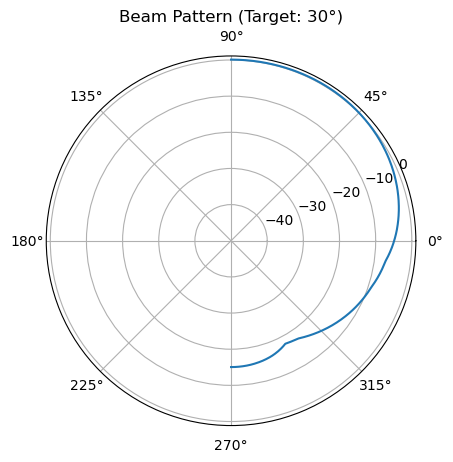

In [34]:
# constants
sound_speed = 343.0
sample_rate = 44100
num_mics    = 8
mic_spacing = 0.04
fft_size    = 1024 # STFT frame size
hop_size    = fft_size // 2
# Match numpy/scipy default: symmetric (non-periodic) window
window      = torch.hamming_window(fft_size, periodic=False)
target_deg  = 30   # beam direction

# precompute steering matrix for MVDR (using STFT fft_size)
freqs = torch.fft.rfftfreq(fft_size, d=1/sample_rate) # Use STFT fft_size
positions = torch.arange(num_mics, dtype=torch.float32) * mic_spacing
target_rad = math.radians(target_deg)

beam_steering = torch.exp(
    -1j * 2 * math.pi
    * freqs[:, None]
    * positions[None, :]
    * math.cos(target_rad) # Original numpy code used cos here
    / sound_speed
).to(torch.complex64) # Ensure complex64

# test tone
signal = make_mono_audio_torch(700,
                                write_wav=False,
                                duration_s=5,
                                sample_rate=sample_rate)
original_signal_length = signal.shape[0] # Store original length

angles       = torch.linspace(-90, 90, 500) # Test angles
responses_db = []
best_angle   = 0.0
max_amp      = -float("inf")

for ang in angles:
    ang_deg = ang.item()
    # simulate arrival at ang_deg using the frequency domain delay function
    multich = delay_across_channels_py_freq_torch(signal,
                                                ang_deg,
                                                num_mics,
                                                mic_spacing,
                                                sample_rate,
                                                sound_speed)
    # --- Beamforming ---
    # STFT: Input shape (num_mics, samples) -> output (num_mics, freq_bins, frames)
    spec = torch.stft(multich.T, # Transpose to (num_mics, samples)
                        n_fft=fft_size,
                        hop_length=hop_size,
                        win_length=fft_size,
                        window=window,
                        return_complex=True,
                        center=True, # Use centering like scipy default
                        pad_mode="constant") # Default padding

    # reorder to (freq_bins, num_mics, frames) for MVDR calculation
    spec = spec.permute(1, 0, 2)
    n_freq_bins = spec.shape[0] # Actual number of freq bins from STFT

    # assume white noise covariance: batch of identity matrices
    # Ensure dtype matches spec and beam_steering complex type
    Rn = torch.eye(num_mics, dtype=torch.complex64).unsqueeze(0).repeat(n_freq_bins, 1, 1)

    # MVDR weights per frequency
    # Ensure W has the correct complex dtype
    W = torch.empty_like(beam_steering, dtype=torch.complex64)
    for k in range(n_freq_bins): # Iterate up to actual freq bins
        # Add regularization (jitter)
        R = Rn[k] + 1e-6 * torch.eye(num_mics, dtype=torch.complex64)
        a = beam_steering[k] # Steering vector for this frequency bin
        # Solve linear system: R * v = a -> v = R^-1 * a
        v = torch.linalg.solve(R, a)
        # Denominator: a^H * R^-1 * a
        denom = torch.vdot(a, v) # vdot computes conj(a) @ v
        # Optimal weights: w = (R^-1 * a) / (a^H * R^-1 * a)
        W[k] = v / denom

    # apply beamformer weights
    # W shape: (freq_bins, num_mics), need conj(W)
    # spec shape: (freq_bins, num_mics, frames)
    # Add frame dimension to W for broadcasting: conj(W)[..., None] -> (freq_bins, num_mics, 1)
    # Sum over mics dimension (dim=1)
    Y = torch.sum(torch.conj(W)[..., None] * spec, dim=1) # Result shape: (freq_bins, frames)

    # Inverse STFT to get time-domain signal
    out_time = torch.istft(Y,
                            n_fft=fft_size,
                            hop_length=hop_size,
                            win_length=fft_size,
                            window=window,
                            length=original_signal_length, # Ensure output length matches input
                            center=True) # Match stft centering

    # Find max amplitude for this angle
    amp = torch.max(torch.abs(out_time)).item()
    if amp > max_amp:
        max_amp    = amp
        best_angle = ang_deg

    # Calculate dB, avoiding log10(0) or very small numbers
    db_val = 20 * math.log10(amp + 1e-9) # Add small epsilon
    db = max(db_val, -50.0) # Clamp to -50 dB floor
    responses_db.append(db)

print(f"Max response at {best_angle:.6f}° → amplitude {max_amp:.6f}")

# plot polar response
angle_rads_np = np.radians(angles.numpy()) # Convert angles tensor to numpy for plotting
plt.polar(angle_rads_np, responses_db)
plt.ylim(bottom=-50) # Set radial limit minimum
plt.title(f"Beam Pattern (Target: {target_deg}°)")
plt.show()